In [2]:
import covasim as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


In [3]:
start_day = '2020-03-02'
end_day   = '2020-07-01'
all_days = cv.date_range(start_day, end_day)
beta_initial=0.015

In [4]:
# defining a moving beta accoding to the article predicting regional covid 19 hospital admissions in Sweden using mobility data

mobility='''0
-0,0436877025562212
-0,142183890633573
-0,414264196497882
-0,490226517606742
-0,520691444229291
-0,601104998394856
-0,565468289968282
-0,500887028474234
-0,533539503417897
-0,489363271950639
-0,479732407975015
-0,525650201055078
-0,4254
-0,4325
-0,394
-0,53
-0,47
-0,5
-0,53
-0,56
-0,55
-0,53
-0,5
-0,47
-0,39
-0,35
-0,34
-0,34
-0,33
-0,33
-0,32
-0,31
-0,32
-0,31
-0,42
-0,41
-0,43
-0,45
-0,44
-0,44
-0,51
-0,51
-0,66
-0,77
'''.replace(',','.').split('\n')


floatmobility = [float(i) for i in mobility if i != '']
betas = [ 4.11 + 6.68 * mob for mob in floatmobility]
betas_by_week=np.array([betas[i//7] for i in range(len(all_days))])
# coeff_betas=[betas_by_week[i+1]/betas_by_week[i] for i in range(len(betas_by_week)-1)]
coeff_betas=[betas_by_week[i]/beta_initial for i in range(len(betas_by_week))]


In [5]:
parameters_sweden=dict(pop_size=1000000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=beta_initial,  # value to change. There seems to be a problem, as when 
                            # I change the value of beta to 0.15, the curve drastically change when it shoudln't. 
                            # with several tries, it seems that the model begins with a value of beta equal to 1. 
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )




In [6]:
# interventions of changing beta
cb_mobility = cv.change_beta(days=all_days, changes=coeff_betas, do_plot=False) # warning, change_beta does not change the value of beta, it multiplies the value of beta_0 by a constant and replaces the previois beta by this new one. 
beta_low=0.5
beta_high=1.2
cb_two_waves=cv.change_beta(days=['2020-03-02', '2020-04-20', '2020-05-25', '2020-06-25', ], changes=[beta_high, beta_low, beta_high, beta_low], do_plot=True)

Initializing sim with 1000000 people for 121 days
Loading location-specific data for "Sweden"
  Running 2020-03-02 ( 0/121) (6.74 s)  ———————————————————— 1%
  Running 2020-03-12 (10/121) (8.03 s)  •——————————————————— 9%
  Running 2020-03-22 (20/121) (11.22 s)  •••————————————————— 17%
  Running 2020-04-01 (30/121) (15.70 s)  •••••——————————————— 25%
  Running 2020-04-11 (40/121) (20.35 s)  ••••••—————————————— 34%
  Running 2020-04-21 (50/121) (24.88 s)  ••••••••———————————— 42%
  Running 2020-05-01 (60/121) (28.92 s)  ••••••••••—————————— 50%
  Running 2020-05-11 (70/121) (33.49 s)  •••••••••••————————— 58%
  Running 2020-05-21 (80/121) (38.16 s)  •••••••••••••——————— 66%
  Running 2020-05-31 (90/121) (42.78 s)  ••••••••••••••—————— 75%
  Running 2020-06-10 (100/121) (47.36 s)  ••••••••••••••••———— 83%
  Running 2020-06-20 (110/121) (52.02 s)  ••••••••••••••••••—— 91%
  Running 2020-06-30 (120/121) (56.57 s)  •••••••••••••••••••— 99%
Simulation summary:
    5,702,320 cumulative infe

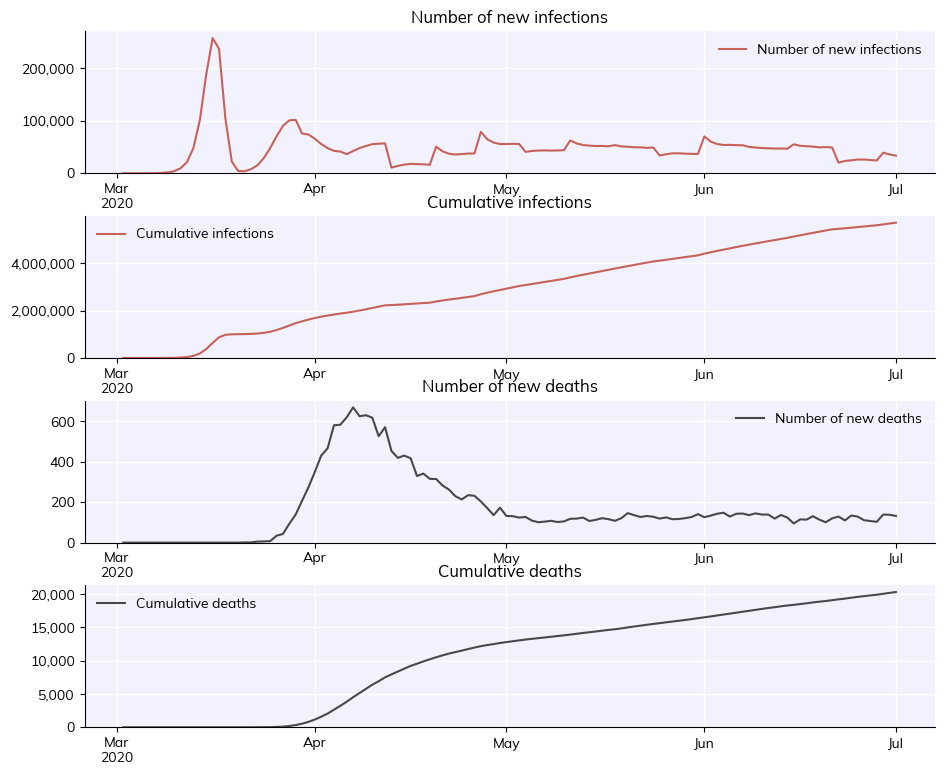

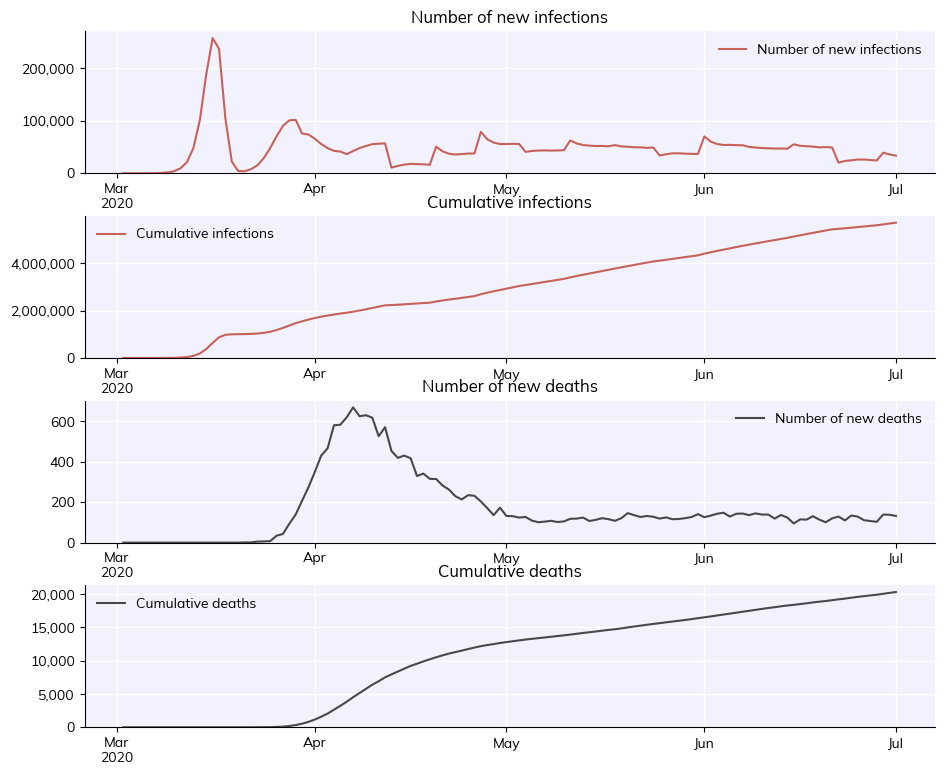

In [7]:
my_simulation_sweden_interventions=cv.Sim(parameters_sweden, interventions=cb_mobility)
my_simulation_sweden_interventions.run()
my_simulation_sweden_interventions.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])


In [8]:
df = pd.read_csv('deaths_and_infections.csv')
# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)

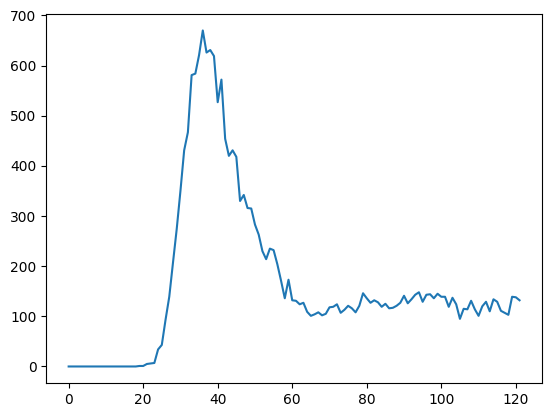

In [9]:
plt.plot(df['new_deaths'], label='new_deaths')
plt.show()

In [10]:
y=np.array(df['new_deaths'])
y_cumul=np.array([sum(y[:i]) for i in range(len(y))])
x=np.arange(len(y))

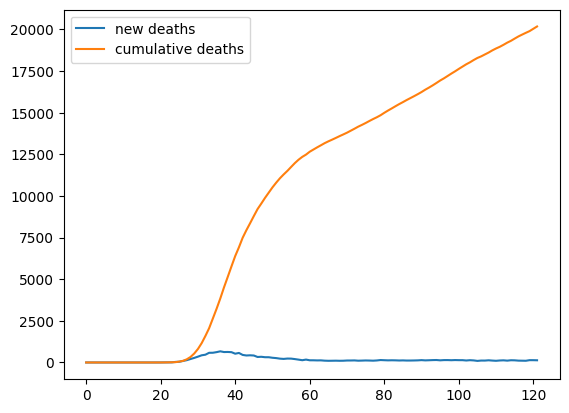

In [11]:
plt.plot(x,y, label='new deaths')
plt.plot(x,y_cumul, label='cumulative deaths')
plt.legend()
plt.show()

In [12]:
def exponential_func(x, a, b, c):
    return a*np.exp(b*x)+c

In [13]:
def polynomla_func(x, a, b, c):
    return a*x**2+b*x+c

In [14]:
p, _ =curve_fit(exponential_func, x, y_cumul)
p
p2, _ =curve_fit(polynomla_func, x, y_cumul)
p2


NameError: name 'curve_fit' is not defined

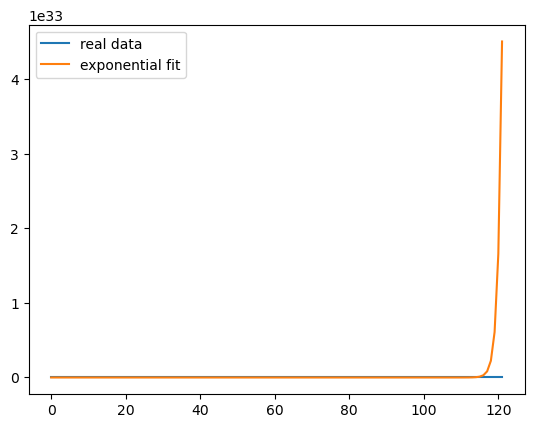

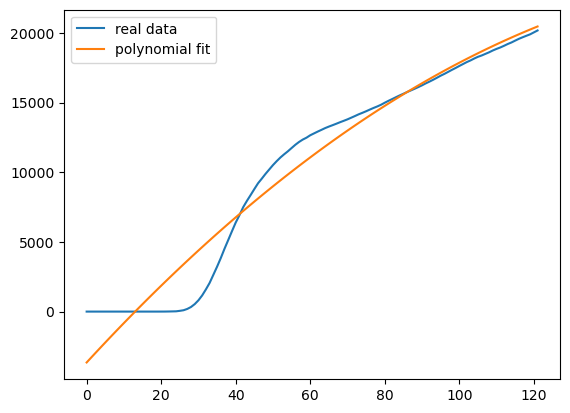

In [ ]:
plt.plot(x,y_cumul, label='real data')
plt.plot(x, exponential_func(x, *p), label= 'exponential fit')
plt.legend()
plt.show()

plt.plot(x,y_cumul, label='real data')
plt.plot(x, polynomla_func(x, *p2), label= 'polynomial fit')
plt.legend()
plt.show()




In [ ]:
def derive(x, beta, N, gamma, d):
    s=x[0]
    i=x[1]
    r=x[2]
    deads=x[3]
    return np.array([-beta*s*i/N, beta*s*i/N - gamma*i - d * i , gamma*i , d * i ])


In [ ]:
def run_sir(x0, beta, gamma,d,  t, dt):
    x=x0
    S=[x[0]]
    I=[x[1]]
    R=[x[2]]
    D=[x[3]] # deads 
    n_iter=int(t/dt)
    N=sum(x0)
    for i in range(n_iter):
        x=x+dt*derive(x, beta, N, gamma, d)
        S.append(x[0])
        I.append(x[1])
        R.append(x[2])
        D.append(x[3])
    s_final=[]
    i_final=[]
    r_final=[]
    d_final=[]
    time=np.linspace(0, t, int(t/dt) )
    for i in range(len(time)-1):
        if abs(time[i]-int(time[i]))<dt: 
            s_final.append(S[i])
            i_final.append(I[i])
            r_final.append(R[i])
            d_final.append(D[i])
    return s_final, i_final, r_final, d_final
    



In [ ]:
def optim_sir(x, beta, gamma, x_0):
    S,I,R=run_sir(x, beta, gamma, t, dt)
    y_pred=np.array(I)
    return sum((y-y_pred)**2)

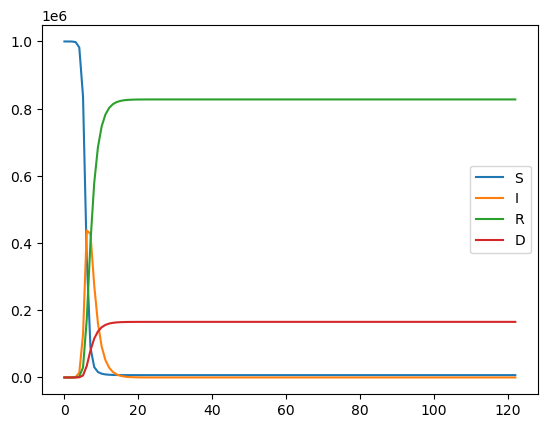

In [ ]:
s_0=1000000 -1
i_0=1
r_0=0
d_0=0
beta=3
gamma=0.5
d=0.1
t=len(y_cumul-1)
dt=0.001
%matplotlib inline
S, I, R , D= run_sir([s_0, i_0, r_0, d_0], beta, gamma,d, t, dt)
time=np.linspace(0, t, t)
plt.plot(time, S,  label='S')
plt.plot(time, I, label='I')
plt.plot(time,R, label='R')
plt.plot(time, D, label='D')
plt.legend()
plt.show()

In [ ]:
def sir_for_optim(x, beta, gamma, d):
    S,I,R,D=run_sir(x, beta, gamma, d, t, dt)
    return D

In [ ]:
p, _= curve_fit(sir_for_optim, [s_0, i_0, r_0, d_0], y_cumul)

C:\Users\grego\AppData\Local\Temp\ipykernel_16748\867619918.py:6: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([-beta*s*i/N, beta*s*i/N - gamma*i - d * i , gamma*i , d * i ])
C:\Users\grego\AppData\Local\Temp\ipykernel_16748\867619918.py:6: RuntimeWarning: invalid value encountered in scalar subtract
  return np.array([-beta*s*i/N, beta*s*i/N - gamma*i - d * i , gamma*i , d * i ])


KeyboardInterrupt: 

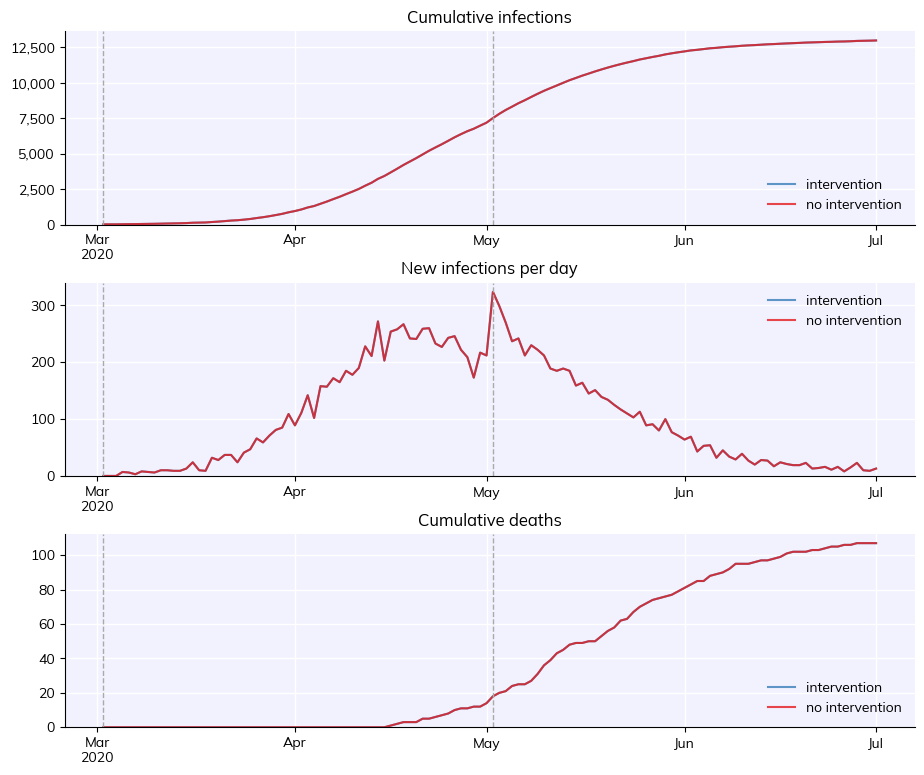

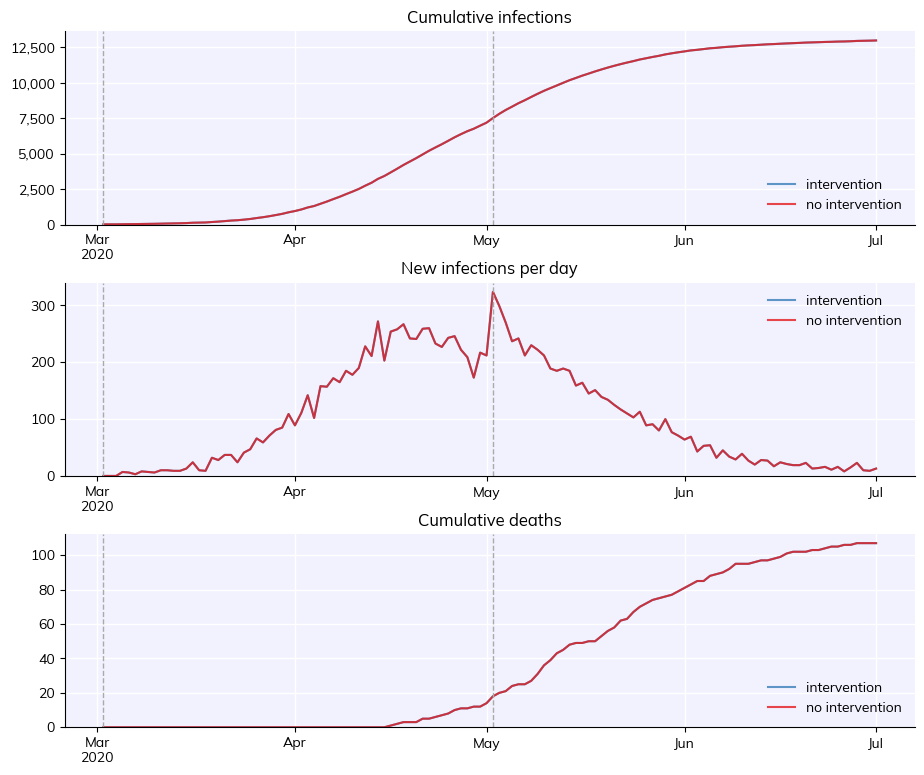

In [ ]:
# THIS CELLE ENABLES TO CHECK WHAT change_beta REALLY DOES






param1=dict(pop_size=10000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=0.015,  # value to change. There seems to be a problem, as when 
                            # I change the value of beta to 0.15, the curve drastically change when it shoudln't. 
                            # with several tries, it seems that the model begins with a value of beta equal to 1. 
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )


param2=dict(pop_size=10000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=1,  # value to change. There seems to be a problem, as when 
                            # I change the value of beta to 0.15, the curve drastically change when it shoudln't. 
                            # with several tries, it seems that the model begins with a value of beta equal to 1. 
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )




cb1=cv.change_beta(days=['2020-03-02',  '2020-05-02',  ], changes=[1, 2], do_plot=True)
cb2=cv.change_beta(days=['2020-03-02',  '2020-05-02',  ], changes=[0.015, 0.03], do_plot=True)

sim1=cv.Sim(param1, interventions=cb1, label='intervention')
sim2=cv.Sim(param2, interventions=cb2, label='no intervention')
msim=cv.MultiSim([sim1, sim2])
msim.run()
msim.plot()

